# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

# Section 0: Initial data exploration

## 0.1 Loading the data
Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple function to load in text files containing the transcripts, figure out who the speakers are, and separate the text blocks into a list of words.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
import mysql.connector
import re

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}

plt.rc('font', **font)

Using TensorFlow backend.


In [3]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [4]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

In [5]:
transcript_df = pull_transcript(n=1500)
transcript_df.tail()

,episode_id,aired_at,url,segment,transcript
id,,,,,
1496,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,panel,\n \n \n \n\n BILL KURTIS: Fro...
1497,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,limerick,"\n \n \n \n\n MIKE PESCA, HOST..."
1498,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,lightning,"\n \n \n \n\n MIKE PESCA, HOST..."
1499,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,predictions,"\n \n \n \n\n MIKE PESCA, HOST..."
1500,201,2016-01-30,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n BILL KURTIS: Fro...


In [6]:
# function to load and process one text files
def Process_Transcript(ID):
    # Load the file
    transcript = transcript_df.loc[ID,'transcript']

    # split the text into words
    words = transcript.split()
    while not words[0][-1] == ':': # remove intro text before the first speaker
        words = words[1:]
    
    # Iterate through all of the words, and find those that correspond to speakers
    names = set([x for x in words if x[-1]==':']) 
    return words, names

## 0.2 Example transcript

Let's print a little bit of the transcript from the first dataset, and see what it looks like.

In [7]:
print(transcript_df.loc[1,'transcript'][:500])


    
        
    

    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).
    (LAUGHTER)
    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.
    PETER SAGAL, HOST: 
    Thank you, Bill. Thank you, everybody.
    (CHEERING)
    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to M


In [8]:
transcript_df.loc[1,'transcript'][:1000]

"\n    \n        \n    \n\n    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).\n    (LAUGHTER)\n    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.\n    PETER SAGAL, HOST: \n    Thank you, Bill. Thank you, everybody.\n    (CHEERING)\n    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to Microsoft co-founder Steve Ballmer. He is, we believe, the richest guest we've ever had. But, of course, your true wealth is measured in your friends. And this just in - he has more friends, too.\n    (LAUGHTER)\n    SAGAL: But first, as many of you know, the NPR podcast feeds got all screwed up last week. People who tried to download our show got, for example, How I Built This instead, for which I apologize. And the people who wanted How I Built This got us, for which I apologize eve

Initially, we can note a number of features. First, audience responses are noted with the '(LAUGHTER)' marker and '(APPLAUSE)' marker. This will prove very useful, as we have an automatic metric for "funniness" of the preceding text. 

Speakers' names are in all caps, followed by a colon. Speakers are also separated by a line break and a tab, which could potentially be used to segment the text into phrases by various people. 

It's probably worth doing a little more processing on these lines, dividing them by speaker, and giving them a marker for applause and laughter if they are followed by applause or laughter. 

In [9]:
def line_info(transcript_number):
    transcript = transcript_df.loc[transcript_number,'transcript'];
    by_lines = transcript.split('\n    ')
    df = pd.DataFrame(by_lines,columns=['lines']) # turn the lines into a dataframe
    
    # if the line contains "APPLAUSE", mark the previous line as "clapping"
    # if the line contains "LAUGHTER", mark the previous line as "funny"
    df['funny'] = False
    df['clapping'] = False
    df.loc[np.where(df.lines=='(LAUGHTER)')[0]-1,'funny'] = True
    df.loc[np.where(df.lines=='(APPLAUSE)')[0]-1,'clapping'] = True
    df.loc[np.where(df.lines=='(CLAPPING)')[0]-1,'clapping'] = True
    df.loc[np.where(df.lines=='(CHEERING)')[0]-1,'clapping'] = True
    
    # for the remaining lines, identify the speaker using regular expressions
    df['speaker'] = ''
    speaker_re = re.compile('[A-Z]+:'); # all-caps word followed by a colon
    full_speaker_re = re.compile('^(.*?)[A-Z]+: ') # all-caps word followed by a colon, and all words preceding
    for idx,line in zip(df.index,df.lines):
        try:
            df.loc[idx,'speaker'] = speaker_re.search(line).group()[:-1]
            df.loc[idx,'lines'] = full_speaker_re.sub('',line)
            
            if df.loc[idx,'speaker'] == 'HOST':
                df.loc[idx+1,'speaker'] = 'SAGAL'
                df.loc[idx,'speaker'] = ''
        except: # skip this if the line doesn't contain a word in the right format to be a speaker
            continue
    
    # drop the lines with no speaker (Applause markers, empty lines, etc.)
    rows_to_remove = df.index[np.where((df.speaker==''))[0]]
    df = df.drop(rows_to_remove)
    
    return df

# calculates the line info dataframe for each transcript in the list, and combines the dataframes
def line_info_multiples(transcript_list):
    dataframe_list = []
    for t in transcript_list:
        dataframe_list.append(line_info(t))
        
        

In [10]:
# show an example processed transcript
transcript1 = line_info(1)
transcript2 = line_info(2)
transcript = pd.concat((transcript1,transcript2))
transcript.tail(20)

,lines,funny,clapping,speaker
182,"Thank you for playing, man.",False,False,SAGAL
5,"Right now, panel, it's time for you to answer ...",False,False,SAGAL
6,They're trying to teach kids what it's like wh...,True,False,GROSZ
8,Can I have a little hint?,False,False,GROSZ
9,"Well, it's, like, well, sometimes, when a piec...",False,False,SAGAL
10,They're trying to teach them sex ed?,False,False,GROSZ
11,Yes.,False,False,SAGAL
13,"To be fair, these are the methods used to teac...",True,False,SAGAL
15,"So, for example, a teacher will stick a piece ...",True,False,SAGAL
17,"So I get the gum, but how do the roses work?",False,False,ROBERTS


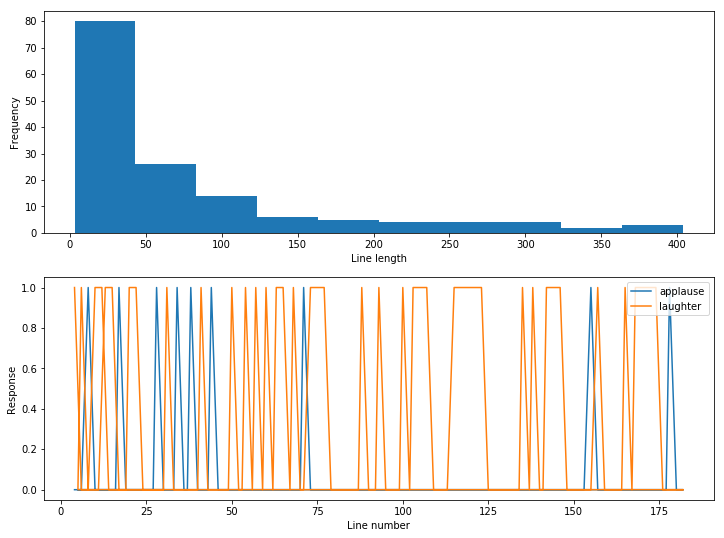

In [11]:
plt.figure(figsize=(12,9))
plt.subplot(2,1,1);
plt.hist(transcript.lines.str.len());
plt.xlabel('Line length')
plt.ylabel('Frequency')

plt.subplot(2,1,2);
plt.plot(transcript.clapping)
plt.plot(transcript.funny);
plt.xlabel('Line number')
plt.ylabel('Response')
plt.legend(['applause','laughter'],loc='upper right')

In [12]:
# plt.plot(transcript.lines.str.len(),'.-')
# plt.plot(transcript.funny*transcript.lines.str.len(),'.')
# plt.xlabel('line number')
# plt.ylabel('line length')

Just for fun, let's make a word cloud visualization of the "Wait wait, don't tell me" dataset. I based the formatting on this on the excellent tutorial by Max Woolf, posted [here](https://minimaxir.com/2016/05/wordclouds/).

In [97]:
from wordcloud import WordCloud, STOPWORDS
import string
from palettable.colorbrewer.sequential import Oranges_9
import random
from PIL import Image

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Oranges_9.colors[random.randint(2,8)])

In [20]:
# concatenate the text from all of the transcripts
text = transcript_df.transcript.str.cat()

In [21]:
# remove all-caps words
caps_re = re.compile('[A-Z]+(?![a-z])')
text = caps_re.sub('',text)

In [67]:
# remove the footer text at the bottom of each transcript
copyright_text = text[-475:]
stopwords = set(STOPWORDS)
stopwords = stopwords.union(set(copyright_text.split()))

In [120]:
# load the mask
# http://stackoverflow.com/questions/7911451/pil-convert-png-or-gif-with-transparency-to-jpg-without
icon_path = './exclamation-sign.png'
icon = Image.open(icon_path)
mask = np.array(icon)
# mask = Image.new("RGB", icon.size, (255,255,255))
# mask.paste(icon)
# mask = np.array(mask)

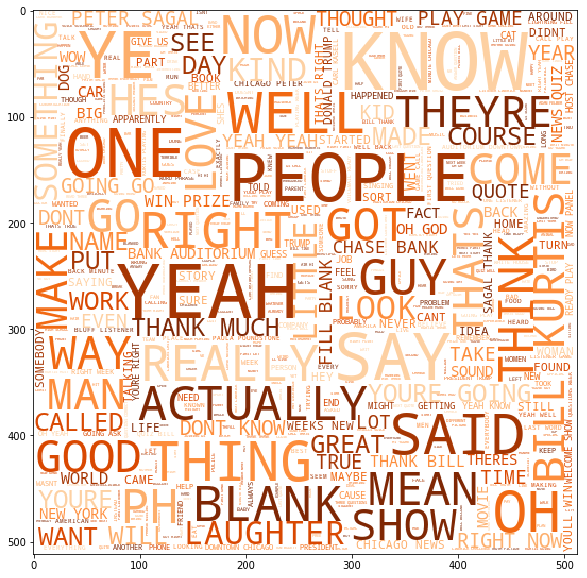

In [121]:
# generate the word cloud
wc = WordCloud(background_color="white", 
               max_words=1000,
               max_font_size=75, 
               random_state=42,
               mask=mask,
               stopwords=stopwords,
               color_func=color_func)
               
# generate word cloud
wc.generate_from_text(text.upper())
plt.figure(figsize=(10,10))
plt.imshow(wc)

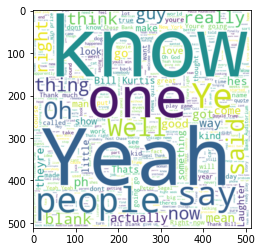

In [122]:
wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# show
plt.imshow(wc, interpolation='bilinear')

# Section 1: Understanding jokes

### 1.1 Who is the funniest panelist? 

The first question I address is which panelist is the funniest. I'm aided in this process by the fact that laughter is marked in the transcripts, with the label "(LAUGHTER)". Thus, I can look at every laugh, and figure out who caused it. But people who talk more are likely to get more laughs than those who don't talk much, on average. So, I will calculate the "**Laugh rate**," defined as the number of laughs each speaker gets per hundred words they speak. I will save my results in a pandas table.

In [ ]:
# generate an empty pandas dataframe to keep track of the results
df = pd.DataFrame(index=[], columns=['num_words','num_segments','num_laughs','num_claps'])
df = df.fillna(0)

# for each transcript, count the words spoken and the number of laughs
for ID in transcript_df.index:
    words, names = Process_Transcript(ID)
    
    # increment the number of segments this person has been seen in
    for speaker in names:
        if speaker == 'HOST:': # Peter Sagal is sometimes referred to as "Host"
            speaker = 'SAGAL:'
        if speaker not in df.index: # add a row if we haven't seen this speaker before
            df.loc[speaker,:] = 0
        df.loc[speaker,'num_segments'] +=1
        continue
    
    # Count the number of words each person says, and the number of laughs they receive
    for word in words:
        # note each time the speaker changes
        if word in names:
            speaker = word
            if speaker == 'HOST:': # Peter Sagal is sometimes referred to as "Host"
                speaker = 'SAGAL:'
            continue
        
        # count laughs
        if 'LAUGHTER' in word:
            df.loc[speaker,'num_laughs'] +=1
            continue
        
        # count applause
        if 'APPLAUSE' in word:
            df.loc[speaker,'num_claps'] +=1
            continue
        
        # count total words
        df.loc[speaker,'num_words'] +=1
        
    # report progress
    if ID % 100 == 0:
        print(ID)

In [ ]:
df.describe() # some summary statistics on the data

In [ ]:
plt.hist(df.num_segments[df.num_segments <1000],bins=20);

We should do some data cleanup at this juncture. In particular, there are may speakers with very few words, or who appear on a single segment. This is because each "call in" gets assigned to a particular speaker. Each show also has a guest speaker, who typically only appears on the "not my job segment. So let's go ahead and remove entries where the speaker appears in under 5 segments, or speaks very few words.

In [ ]:
# remove the speakers with less than 2000 words (call-in guests and the like)
df = df[df['num_segments'] > 10]
df = df[df['num_words'] > 500]

In [ ]:
# Now divide the number of laughs by the number of words to get the laugh rate (laughs per hundred words)
df['laughs_per_word'] = 100*df['num_laughs']/df['num_words']
df['laughs_per_segment'] = df['num_laughs']/df['num_segments']
df['clap_rate'] = 100*df['num_claps']/df['num_words']
df.sort_values('laughs_per_word',ascending=False)

In [ ]:
plt.figure(figsize=(20,5));
plt.plot(df.sort_values('laughs_per_word',ascending=False).laughs_per_word,'o');
plt.xlabel('panelist');
plt.ylim([0,np.ceil(df.laughs_per_word.max())])
plt.ylabel('laughs per hundred words');

In [ ]:
plt.scatter(df.num_segments[df.num_segments<400],df.laughs_per_word[df.num_segments<400])

### Conclusions, further questions
It looks like our winner is Helen Hong! With 3.5 laughs per hundred words, Hong leaves runner-up Jessi Klein in the dust. 
Looking at our data table, we can also see that Helen Hong has fewer total words spoken than others. Alternatively, if we have fewer samples that might tend to lead to noisier estimates for the people who talk less, leading them to have more variance in the estimate of "funniness." Might how much a person talks be negatively related to funniness? Or do shorter digressions tend to be funnier? What other properties can predict laughter?

### Questions to address:
1. What are the funniest words? 
    - Examine the words that precede laughs, look for trends.
    - Weight by word frequency in whole show. (percent of time the word elicited a laugh)
    - Eliminate "common" words (the, and, ...)
2. Build a laugh predictor:
    - Based on a set of words
    - RNN
    - Markov model?

### 1.2 What are the funniest words?

In our quest to predict laughter, one reasonable thing to consider is which words or phrases tend to precede laughs. Are there any major trends in these words? To do this, I will count all of the words that precede laughter, and compare it with total word counts.

In [ ]:
# Store the data in a dictionary
all_words = {}
funny_words = {}

In [ ]:
# start out by processing one transcript
transcript_df.loc[1,'transcript']

In [ ]:
def transcriptToFreqDict(transcript):
    wordlist = transcript.split()
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

In [ ]:
transcriptToFreqDict(transcript_df.loc[1,'transcript'])

# How is laughter distributed through a show?

In [ ]:
plt.figure(figsize=(10,20))
for file_idx,file in zip(range(len(files)),files):
    words, names,transcript = Load_Transcript(data_dir+file)
    
    # note where in the transcript laughs occured
    laughs = np.zeros(len(words))
    speaker_change = np.zeros(len(words))
    for word_idx, word in zip(range(len(words)), words):
        if 'LAUGHTER' in word:
            laughs[word_idx] = 1
    plt.subplot(20,1,file_idx+1)
    plt.plot(np.convolve(laughs,np.ones(100),mode='same'))
    plt.xlim([0,2000])
    plt.ylim([0, 6.5])
    plt.text(1900,5,file,ha='right')

plt.xlabel('Word in transcript');
plt.ylabel('Laugh rate (laughs per hundred words)');

# Can we create our own Wait Wait Don't Tell Me content?

In [ ]:
# Load all of the transcripts
transcript_list = []
chars = set()
for file in files:
    _,_,transcript = Load_Transcript(data_dir+file)
    transcript_list.append(transcript)


In [ ]:
# build a tokenizer to convert the words to integers
vocab_size = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ')
tokenizer.fit_on_texts(transcript_list)
encoded_transcripts = tokenizer.texts_to_sequences(transcript_list)

In [ ]:
help(tokenizer.sequences_to_texts)

In [ ]:
tokenizer.sequences_to_texts([encoded_transcripts[1]])

In [ ]:
# split up the model
train_len = 50
x = []
y = []
for transcript in encoded_transcripts:
    for word in range(0,len(transcript)-train_len-1,3):
        x.append(transcript[word:word+train_len])
        y.append(transcript[word+train_len+1])
x = np.array(x)
y = np.array(y)

from keras.utils import to_categorical
y_binary = to_categorical(y,num_classes=vocab_size)

In [ ]:
# build the model
model = keras.Sequential()
model.add(Embedding(vocab_size, 28, input_length=train_len))
model.add(GRU(128))
model.add(Dense(vocab_size, activation='softmax'))

optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

In [ ]:
# print_callback = LambdaCallback(on_epoch_end=on_epoch_end
history = model.fit(x, y_binary,
              batch_size=128,
              epochs=5,
              validation_split=.1,
              shuffle = True,
    #           callbacks=[on_epoch_end]
             )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
from numpy import random
import sys

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(len(x))
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)
        
        
        generated_decoded = ''
        sentence = x[start_index]
        generated_encoded = sentence
        generated_decoded += tokenizer.sequences_to_texts([sentence])[0]
        print('----- Generating with seed: "' + generated + '"')

        for i in range(400):
            x_pred = generated_encoded[-train_len:]
            
            preds = model.predict(x_pred, verbose=0)[0]
            
            next_index = sample(preds, diversity)
            next_char = num_to_char[next_index]

            generated += next_char
            sentence = generated[-train_len:]

        print(generated)


In [ ]:
generated_decoded = ''
sentence = x[10]
generated_encoded = sentence
generated_decoded += tokenizer.sequences_to_texts([sentence])[0]
print('----- Generating with seed: "' + generated + '"')


for i in range(400):
    x_pred = generated_encoded[-train_len:]
    preds = model.predict(x_pred, verbose=0)


In [ ]:
x_pred = generated_encoded[-train_len:]
x_pred.shape

In [ ]:
model.predict(x_pred)

In [ ]:
x